In [12]:
# demo pipeline met lgb en LSTM pytorch netwerk
%load_ext lab_black
import pandas as pd
import numpy as np
import os
import lightgbm as lgb
from sklearn.decomposition import PCA
import glob

In [1]:
def gather_df(dataset_name):
    assert dataset_name
    df = pd.read_csv('./data/{}.csv'.format(dataset_name), parse_dates=['Date'], dayfirst=True, index_col=['Date'])
    df.columns = df.columns.str.lower()
    df['doy'] = df.index.dayofyear
    df['year'] = df.index.year
    df['week'] = df.index.week
    df['day'] = df.index.day
    df['month'] = df.index.month
    # df = df.drop('date', 1).sort_index()
    return df

In [344]:
related_datas = []
for col in df.columns:
    if 'rain' in col:
        location = col.replace('rainfall_', '').replace('_', ' ')
        filename = './data/nasa-power/{}.pckl'.format(location.title())
        if os.path.exists(filename):
            df_related = pd.read_pickle(filename)
            df_related.columns = ['{}_{}'.format(location, c.lower()) for c in df_related.columns]
            related_datas.append(df_related)
df_related = pd.concat(related_datas)
df_related = df_related.groupby(df_related.index).max()
df_features = df.copy()
df_features = pd.merge(df_features, df_related, how='left', left_index=True, right_index=True)
for dropcol in ['year', 'week', 'day', 'hydrometry_nave_di_rosano', 'doy']:
    df_features = df_features.drop(dropcol, axis=1)
df_features['rolling_target_10'] = df.hydrometry_nave_di_rosano.rolling(10).mean()
df_features['rolling_target_10_std'] = df.hydrometry_nave_di_rosano.rolling(10).std()
df_features['rolling_target_shifted_1year'] = df.hydrometry_nave_di_rosano.shift(365-pred_ahead)

In [345]:
# for col in df_features.columns:
#     if '-' in col:
#         continue
#     for period in [5, 10, 30, 60, 300]:
#         df_features['{}-{}-mean'.format(period, col)] = df_features[col].rolling(period).mean()
#         df_features['{}-{}-std'.format(period, col)] = df_features[col].rolling(period).std()

df = df.sort_index()
X = df[[c for c in df.columns if c not in ('hydrometry_nave_di_rosano')]]
y = df.hydrometry_nave_di_rosano


In [346]:
model = lgb.LGBMRegressor()
pred_ahead = 30
split = 5000
X_pca = df_features.values
model.fit(X_pca[:split], y[pred_ahead:split+pred_ahead].ffill())

LGBMRegressor()

In [347]:
p = model.predict(X_pca[split:-pred_ahead])
dfr = pd.DataFrame({
    'p': p,
    'y': y[split+pred_ahead:]
})


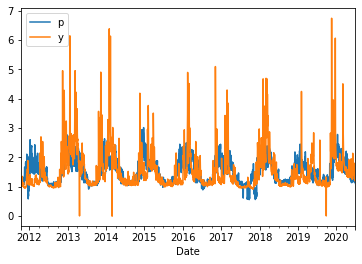

In [348]:
dfr.plot()

In [349]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(dfr.iloc[:].p, dfr.iloc[:].y.ffill())
mse, np.sqrt(mse)
# met time features
# (0.3545128065006366, 0.5954097803199379)
# zonder (0.3231138377387032, 0.5684310316464991)

(0.3231138377387032, 0.5684310316464991)

In [350]:
df_feat_imp = pd.DataFrame({
    'name': df_features.columns,
    'importance': model.feature_importances_
}).sort_values('importance')
df_feat_imp.iloc[-10:]

,name,importance
12,rainfall_bibbiena,45
26,cavallina_ps,45
32,cavallina_ws10m_range,53
31,cavallina_t2m_range,54
28,cavallina_rh2m,57
14,temperature_firenze,102
15,month,151
144,rolling_target_shifted_1year,168
143,rolling_target_10_std,193
142,rolling_target_10,213


In [13]:
from network import *

/home/opt/anaconda/lib/python3.8/site-packages/wandb/util.py:35: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import namedtuple, Mapping, Sequence
/home/opt/anaconda/lib/python3.8/site-packages/wandb/vendor/graphql-core-1.1/graphql/type/directives.py:55: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  assert isinstance(locations, collections.Iterable), 'Must provide locations for directive.'


In [375]:
from sklearn.preprocessing import LabelBinarizer

for i in range(1,13):
    df_features['month_is_{}'.format(i)] = (df_features.index.month == i).astype(int)


In [16]:
from network import *

p = dict(
    seq_len = 28,
    batch_size = 60,
    criterion = nn.MSELoss(),
    max_epochs = 100,
    n_features = df_features.shape[1],
    hidden_size = 100,
    num_layers = 2,
    dropout = 0.2,
    learning_rate = 0.001,
)

model = LSTMRegressor(
    n_features = p['n_features'],
    hidden_size = p['hidden_size'],
    seq_len = p['seq_len'],
    batch_size = p['batch_size'],
    criterion = p['criterion'],
    num_layers = p['num_layers'],
    dropout = p['dropout'],
    learning_rate = p['learning_rate']
)


seed_everything(1)

csv_logger = CSVLogger('./', name='lstm', version='0'),

trainer = Trainer(
    max_epochs=p['max_epochs'],
    logger=csv_logger,
    gpus=1
)

NameError: name 'df_features' is not defined

In [385]:
dm = MyDataModule(
    features = df_features.ffill().bfill().values,
    target=df.hydrometry_nave_di_rosano.ffill().values,
    seq_len = p['seq_len'],
    batch_size = p['batch_size']
)
print(dm.columns)
trainer.fit(model, dm)

/home/opt/anaconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Experiment logs directory ./lstm/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 184 K 
2 | linear    | Linear  | 101   


None


/home/opt/anaconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/opt/anaconda/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/opt/anaconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/opt/anaconda/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([53])) that is different to the input size (torch.Size([53, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/home/opt/anaconda/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1

In [386]:
trainer.test(model, dm.test_dataloader())

/home/opt/anaconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.1352, device='cuda:0'),
 'train_loss': tensor(1.8625, device='cuda:0'),
 'val_loss': tensor(0.1352, device='cuda:0')}
--------------------------------------------------------------------------------



/home/opt/anaconda/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/opt/anaconda/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[{'train_loss': 1.8625108003616333,
  'val_loss': 0.13521209359169006,
  'test_loss': 0.13521209359169006}]

In [ ]:
# lgbm heeft ongeveer .32 MSE, LSTM ongeveer .136